# Домашняя работа "Аналитика"

# Часть I: исходные данные

### Задача 1: Конверсия в просмотр

Напишите запрос, который сравнит конверсию в просмотр между двумя странами: Россия и Украина

* сгруппируйте данные по полям страна + день
* исключите просмотры, которые были совершены в субботу и воскресенье

In [142]:
import datetime
import logging
import os
from subprocess import call

import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import pandas as pd

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
# движок нужен для подключения к Postgres
engine = create_engine('postgresql://postgres:@{}'.format(os.environ['APP_POSTGRES_HOST']))

# ----- ВАШ КОД ТУТ  -------


sql_str = """
SELECT    
    date,
    to_char(to_timestamp(rocket_datetime),'Day') as dw,
    country,
    SUM(content_watch)::float / SUM(content_impression)::float as conversion    
FROM (
    SELECT
        rocket_datetime,
        user_id_for_mai,
        content_id,
        country,
        to_char(to_timestamp(rocket_datetime), 'YYYY-MM-DD') as date,
        MAX(CASE WHEN name in ('page_impression', 'click') THEN 1 ELSE 0 END) as content_impression,
        MAX(CASE WHEN name='content_watch' THEN 1 ELSE 0 END) as content_watch
    FROM movie.events
    WHERE
        content_id > 0
        AND country in ('Украина', 'Россия')
        AND EXTRACT(DOW FROM to_timestamp(rocket_datetime)) < 6
        AND EXTRACT(DOW FROM to_timestamp(rocket_datetime)) > 0
    GROUP BY user_id_for_mai, content_id, date, country, rocket_datetime
) as content_watches
WHERE
    content_impression > 0
GROUP BY date, country, dw
ORDER BY date

"""


# ----- ВАШ КОД ТУТ  -------

conversion_df = pd.read_sql(sql_str, engine)

conversion_df


,date,dw,country,conversion
0,2019-06-03,Monday,Россия,0.000944
1,2019-06-03,Monday,Украина,0.000000
2,2019-06-04,Tuesday,Россия,0.000000
3,2019-06-04,Tuesday,Украина,0.000000
4,2019-06-05,Wednesday,Россия,0.000000
...,...,...,...,...
125,2019-08-28,Wednesday,Украина,0.002941
126,2019-08-29,Thursday,Россия,0.000799
127,2019-08-29,Thursday,Украина,0.000000
128,2019-08-30,Friday,Россия,0.000577


Визуализация: постройте графики изменения конверсии по дням

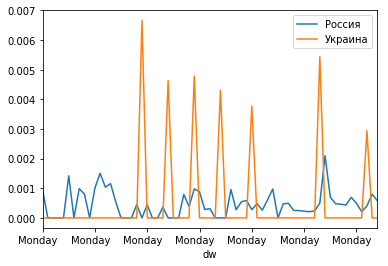

In [143]:
%matplotlib inline

df1 = conversion_df[conversion_df['country']=='Россия']
df2 = conversion_df[conversion_df['country']=='Украина']


ax = df1.plot(x='dw', y='conversion', label='Россия')
df2.plot(x='dw', y='conversion', ax=ax, label='Украина')


Визуализация: постройте гистограмму распределения конверсии

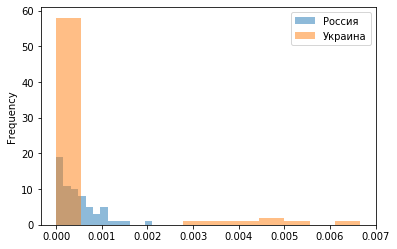

In [144]:
ax = conversion_df[
    conversion_df['country']=='Россия'
]['conversion'].plot(kind='hist', alpha=0.5, bins=13, label='Россия', legend=True)

conversion_df[
    conversion_df['country']=='Украина'
]['conversion'].plot(kind='hist', alpha=0.5, bins=12, label='Украина', legend=True)

### Задача 2:  Retention

Посчитайте возвращаемость (недельную) пользователей на сервис на день X

* найдите множество $y1$ пользователей, которые заходили в период от $X-14$ до $X-7$
* найдите множество $y2$, которые заходили в период от $X-6$ до $X$
* найдите пересечение множеств $y1$ и $y2$ и разделите его на объединение этих множеств - это и будет наша метрика retention

In [145]:
import datetime
import logging
import os
from subprocess import call

import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import pandas as pd

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
# движок нужен для подключения к Postgres
engine = create_engine('postgresql://postgres:@{}'.format(os.environ['APP_POSTGRES_HOST']))

# ----- ВАШ КОД ТУТ  -------

def retention(date, subsite_title):
    date1 = date
    subsite_title1 = subsite_title
    sql_str1 = """
    DROP TABLE if exists T1,T2,T3,T4, y1,y2 CASCADE;
    
    CREATE TABLE T1 AS
    SELECT 
        distinct user_id_for_mai,
        subsite_title,
        to_date(to_char(to_timestamp(rocket_datetime), 'YYYY-MM-DD'), 'YYYY-MM-DD') as date
    FROM movie.events
    WHERE 
        to_date(to_char(to_timestamp(rocket_datetime), 'YYYY-MM-DD'), 'YYYY-MM-DD') >= '{0}'::date 
        AND to_date(to_char(to_timestamp(rocket_datetime), 'YYYY-MM-DD'), 'YYYY-MM-DD') < '{0}'::date + interval '6 days'
        AND subsite_title = '{1}'
    ORDER BY date; 
    
    CREATE TABLE T2 AS
    SELECT 
        distinct user_id_for_mai,
        to_date(to_char(to_timestamp(rocket_datetime), 'YYYY-MM-DD'), 'YYYY-MM-DD') as date,
        subsite_title
    FROM movie.events
    WHERE 
        to_date(to_char(to_timestamp(rocket_datetime), 'YYYY-MM-DD'), 'YYYY-MM-DD') >= '{0}'::date + interval '7 days'
        AND to_date(to_char(to_timestamp(rocket_datetime), 'YYYY-MM-DD'), 'YYYY-MM-DD') < '{0}'::date + interval '14 days'
        AND subsite_title = '{1}'
    ORDER BY date;
    
    CREATE TABLE T3 AS
    SELECT user_id_for_mai FROM T1 INTERSECT SELECT user_id_for_mai FROM T2;
    
    CREATE TABLE T4 AS
    SELECT user_id_for_mai FROM T1 UNION SELECT user_id_for_mai FROM T2;
    
    Create TABLE y1 as 
    SELECT count(user_id_for_mai) as c1 FROM T3;
    
    Create TABLE y2 as 
    SELECT count(user_id_for_mai) as c2 FROM T4;
    
    SELECT c1,c2 FROM y1,y2
    
    """.format(date1, subsite_title1)

    # ----- ВАШ КОД ТУТ  -------
    df = pd.read_sql(sql_str1, engine)
    a = df['c1'][0]/df['c2'][0]
    #y1 = pd.read_sql(sql_str2, engine)
    #inter = pd.Series(np.intersect1d(y1["user_id_for_mai"],y2["user_id_for_mai"]))
    #join = pd.Series(np.concatenate((y1["user_id_for_mai"],y2["user_id_for_mai"]), axis=None))
    #a= len(inter.index)/len(join.index)
    #inter.head(30)
    #join.head(30)
    #np.concatenate?
    return a
date = '2019-06-17'
subsite_title = 'Windows 10'
ret=retention(date, subsite_title)
ret

0.13772090188909203

Постройте гистограмму ретеншна - на какой платформе лучше возвращаемость?

In [146]:

sql_str = """
SELECT
    date,
    subsite_title,
    SUM(content_watch)::float / SUM(content_impression)::float as conversion
FROM (
    SELECT
        user_id_for_mai,
        content_id,
        subsite_title,
        to_char(to_timestamp(rocket_datetime), 'YYYY-MM-DD') as date,
        MAX(CASE WHEN name in ('page_impression', 'click') THEN 1 ELSE 0 END) as content_impression,
        MAX(CASE WHEN name='content_watch' THEN 1 ELSE 0 END) as content_watch
    FROM movie.events
    WHERE
        content_id > 0
        AND subsite_title in ('xboxOne', 'Windows 10')
    GROUP BY user_id_for_mai, content_id, date, subsite_title
) as content_watches
WHERE
    content_impression > 0
GROUP BY date, subsite_title
ORDER BY date, subsite_title

"""

conversion_df = pd.read_sql(sql_str, engine)

conversion_df['retention'] = conversion_df.apply(lambda x: retention(x['date'],x['subsite_title']), axis=1)
conversion_df

,date,subsite_title,conversion,retention
0,2019-06-01,Windows 10,0.197802,0.084732
1,2019-06-01,xboxOne,0.200704,0.151134
2,2019-06-02,Windows 10,0.287532,0.096525
3,2019-06-02,xboxOne,0.270677,0.172030
4,2019-06-03,Windows 10,0.439331,0.093704
...,...,...,...,...
179,2019-08-29,xboxOne,0.374055,0.000000
180,2019-08-30,Windows 10,0.423216,0.000000
181,2019-08-30,xboxOne,0.383515,0.000000
182,2019-08-31,Windows 10,0.482902,0.000000


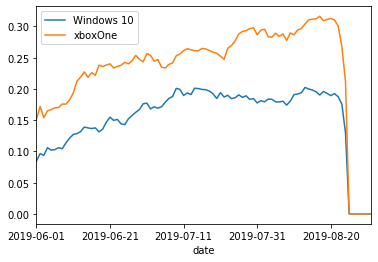

In [147]:
%matplotlib inline

df1 = conversion_df[conversion_df['subsite_title']=='Windows 10']
df2 = conversion_df[conversion_df['subsite_title']=='xboxOne']

ax = df1.plot(x='date', y='retention', label='Windows 10')
df2.plot(x='date', y='retention', ax=ax, label='xboxOne')

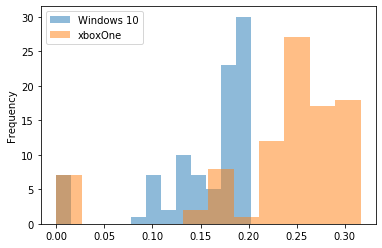

In [148]:
# Windows 10
ax = conversion_df[
    conversion_df['subsite_title']=='Windows 10'
]['retention'].plot(kind='hist', alpha=0.5, bins=13, label='Windows 10', legend=True)

# xboxOne
conversion_df[
    conversion_df['subsite_title']=='xboxOne'
]['retention'].plot(kind='hist', alpha=0.5, bins=12, label='xboxOne', legend=True)

# Часть II статистические гипотезы

### Задача 3: Предсказательный интервал

пусть результат эксперимента представляет собой нормально распределённую СВ $X\sim N(\mu, \sigma)$. Тогда предсказательный интервал имеет вид
$$
P\left(\mu - Z_{\frac{\alpha}{2}}\sigma \le X \le \mu + Z_{\frac{\alpha}{2}} \right) = 1 - \alpha
$$

для тренировки сгенерируйте решите задачу: постройте предсказательный интервал для случайной величины $X\sim N(\mu, \sigma)$:

In [149]:
from scipy.stats import norm

mu = 5
sigma = 0.9
# используйте функцию ppf - Percent point function (обратная к кумулятивной функции (функции вероятности) cdf)

z_05 = None
z_95 = None

print(f"z_05 = {z_05}, z_95 = {z_95}")

z_05 = None, z_95 = None


Проверка на правильность решения

In [150]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(z_05, 3.5196, places=4)
        self.assertAlmostEqual(z_95, 6.4804, places=4)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... ERROR

ERROR: test_task (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-150-6092bbca14c6>", line 5, in test_task
    self.assertAlmostEqual(z_05, 3.5196, places=4)
  File "/usr/lib/python3.6/unittest/case.py", line 871, in assertAlmostEqual
    if round(abs(second-first), places) == 0:
TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (errors=1)


### Задача 4: Доверительный интервал для математического ожидания гауссовской СВ.

СВ $X\sim N(\mu, \sigma)$, где $\sigma$ известный параметр. По результатам эксперимента получили выборку $X^n = \left( X_1,\ldots,X_n \right)$. Задача - оценить по выборке неизвестный параметр $\mu$.

Чтобы построить доверительный интервал параметра $\mu$ в первую очередь нужно понять, какое распределение имеет параметр, который мы исследуем. В данном случае мы можем воспользоваться результатами ЦПТ:
$$
\overline{X} \sim N\left(\mu, \frac{\sigma^2}{n}\right), \overline{X} = \frac{\sum_{i=1}^{n}X_i}{n}
$$

где $\overline{X}$ - среднее значение элементов выборки. В таком случае доверительный интервал имеет вид
$$
P\left(\overline{X} - z_{\alpha/2}\sqrt{\sigma^2/n} \le  \mu \le \overline{X} + z_{\alpha/2}\sqrt{\sigma^2/n}\right) = 1 - \alpha
$$

Для определения значения квантили можно пользоваться функцией `.ppf` из модуля `scipy.stats`.

In [151]:
from scipy.stats import norm
import numpy as np

mu = 5
sigma = 0.9
X = np.array([13.27543316, 18.60619498, 28.64266817, 45.4103895, 10.08409655,
     44.91948425, 47.23376343, 33.03988962, 31.45570219, 3.089313523])

# используйте функцию ppf для нахождения квантили
alpha = 0.05

n = None
left_border = None
right_border = None

print(f"Оценка математического ожидания по выборке mu = [{left_border}, {right_border}]")

Оценка математического ожидания по выборке mu = [None, None]


Тесты на решение

In [152]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(left_border, 28.1335, places=4)
        self.assertAlmostEqual(right_border, 27.0179, places=4)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... ERROR

ERROR: test_task (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-152-015e3b9d4b2c>", line 5, in test_task
    self.assertAlmostEqual(left_border, 28.1335, places=4)
  File "/usr/lib/python3.6/unittest/case.py", line 871, in assertAlmostEqual
    if round(abs(second-first), places) == 0:
TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (errors=1)


### Задача 5: конверсии

#### Вычисление конверсии

Посчитайте конверсию по выборке - нужно написать несложный код на python

In [153]:
import pickle

with open('data/pool_sample.pkl', 'rb') as f:
    pool_data = pickle.load(f)

conversion = None
# ---- ВАШ КОД ТУТ ---

print(pool_data)

# --------------------

[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]


Тесты

In [154]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(conversion, 0.77, places=2)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... ERROR

ERROR: test_task (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-154-090997cc5443>", line 5, in test_task
    self.assertAlmostEqual(conversion, 0.77, places=2)
  File "/usr/lib/python3.6/unittest/case.py", line 871, in assertAlmostEqual
    if round(abs(second-first), places) == 0:
TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (errors=1)


#### Репрезентативный объём выборки

Значение $n$ выборка будет репрезентативной:

$$
n = \left( \frac{Z_{1-\frac{\alpha}{2}}}{\delta}\right)^2pq
$$

Каким образом определить значения $p,q$:
1. из прошлых исследований;
1. еcли дополнительной информации нет, то выбрать $p=q=\frac12$;
1. если известен интервал для $p\in[\alpha, \beta]$, то нужно выбирать значение, максимально близкое к $\frac12$

За кандидата собираются голосовать 30-40%. Сколько нужно опросить респондентов, чтобы оценить долю голосов за кандидата с точность $2\%$.

Написать функцию, которая рассчитывает объём репрезентативной выборки

In [155]:
import math

# подсказка - воспользуйтесь функцией math.ceil()

def representative_sample_size(alpha, delta, p=None):
    """Функция для расчёта объёма репрезентативной выборки
    
    :param alpha: уровень доверия
    :param delta: точность
    :param p (list | int | None): теоретическая вероятность успеха 
    :return: 
    """
    n = None
    # ---- ВАШ КОД ТУТ ---
    
    
    
    # --------------------
    return n

sample_size = representative_sample_size(alpha=0.05, delta=0.03)

Тесты

In [156]:
import unittest

sample_size = representative_sample_size(alpha=0.05, delta=0.03, p=0.4)

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertEqual(sample_size, 1025)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... FAIL

FAIL: test_task (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-156-0a6cef3e425b>", line 7, in test_task
    self.assertEqual(sample_size, 1025)
AssertionError: None != 1025

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (failures=1)


#### Моделирование данных

Смоделируйте эксперимент с соц-опросом с помощью распределения Бернулли

* сгенерируйте выборку того размера, который рассчитали
* посчитайте прогнозируемый рейтинг кандидата 

In [157]:
import scipy.stats as sts

# ---- ВАШ КОД ТУТ ---

p = 0.4  # задайте тут правильное значение
print(f'Размер выборки: {sample_size}') # sample_size должна была сохраниться с предыдущей ячейки

bernoulli_rv = sts.bernoulli(p) # эту часть менять не надо

# поищите в документации как генерить выборки
# вызовите правильный метод объекта bernoulli_rv
# используйте параметр random_state = 42


estimated_rating = 999

# --------------------



Размер выборки: None


Тесты - проверяем рейтинг

In [158]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(estimated_rating, 0.3922, places=4)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... FAIL

FAIL: test_task (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-158-528380472422>", line 5, in test_task
    self.assertAlmostEqual(estimated_rating, 0.3922, places=4)
AssertionError: 999 != 0.3922 within 4 places

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (failures=1)


## Задача на одновыборочный z-критерий


Статиcтика критерия:
$$
Z(X^n) = \frac{\overline{X}- μ_0}{\frac{\sigma}{\sqrt{n}}}
$$

Нулевое распределение: 
$$
Z(X^n) \sim N(0,1)
$$

На уровне значимости $\alpha$ гипотеза $H_0$ отвергается при значении статистики $Z(X^n)=z$ таком, что $z \lt z_\alpha$, где $z_\alpha$ - значение квантили нормального распределения уровня $\alpha$.


Средняя масса детей в неблагополучных семьях при рождении 2.8 кг.
В экспериментальной программе ведения беременности участвовали 25 женщин.	
Средний вес младенцев в экспериментальной группе составил 3.075 кг.
Является ли данное отклонение статистически значимым на уровне доверительной вероятности $\alpha=0.05$? Исходя из прошлых иследований известно, что вес имеет нормальное распределение с $\sigma = 0.5$

Основная гипотеза H0:		X_среднее = 2.8

Альтернативная гипотеза H1		X_среднее > 2.8

In [159]:
from scipy.stats import norm

# Размер выборки
n = 25
# С.К.О.
sigma = 0.5
# Уровень доверия 
alpha = 0.05
# Значение квантили
z_095 = norm.ppf(q=1-alpha)
# Ср. знач. в ген. совокупности
global_mean = 2.8
# Ср. знач. в эксперименте
sample_mean = 3.075

# ---- ВАШ КОД ТУТ ---


# Считаем статистику
Z_x = 0
# Критическая область:
Z_critical = 0
print("Является ли отклонение значимым {}".format(Z_x > Z_critical))


# --------------------

Является ли отклонение значимым False


Тесты - проверяем, что правильно вычислено значение статистики

In [160]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(Z_x, 2.75, places=2)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... FAIL

FAIL: test_task (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-160-94fa367bac92>", line 5, in test_task
    self.assertAlmostEqual(Z_x, 2.75, places=2)
AssertionError: 0 != 2.75 within 2 places

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (failures=1)


### Задача на проверку z-критерия

На прошедшей неделе в рекламной сети параллельно размещалось два баннера Яндекс.Такси. Оба баннера были показаны один миллион раз. Первый получил 10 000 кликов и 500 установок, а второй — 10 500 кликов и 440 установок. Маркетолог просит у вас совета: какой баннер оставить, а какой отключить? Что вы ему ответите?

Статистика критерия
$$
Z(X^{n_1}, X^{n_2}) = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}, Z(X^{n_1}, X^{n_2}) \sim (N(0,1)
$$

где $\hat{p}_{(1,2)}$ - доля успехов в выборках 1 и 2 и
$$
\hat{p}=\frac{(p_1n_1+ p_2n_2  )}{n_1+ n_2}
$$


In [161]:
#banner 1
n1_click = None
n1_installs = None

#banner 2
n2_click = None
n2_installs = None

# ctr
p1 = None
p2 = None

# значение статистики критерия
T_x = 0

# квантиль уровня 0.95 нормального распределения
z_095 = 0

print("Верная ли нулевая гипотеза о равенстве долей: {}".format(T_x > z_095))

Верная ли нулевая гипотеза о равенстве долей: False


Тесты - проверяем, что правильно вычислено значение статистики

In [162]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(T_x, 2.7698, places=4)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... FAIL

FAIL: test_task (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-162-38b70630405a>", line 5, in test_task
    self.assertAlmostEqual(T_x, 2.7698, places=4)
AssertionError: 0 != 2.7698 within 4 places

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (failures=1)


### Проверка продуктовых гипотез

Вернитесь к I части этой домашней работы. Проверьте с помощь статистических критерий несколько гипотез

* конверсия на Windows выше, чем на XboX
* конверсия в Украине  отличается от конверсии в России
* retention на XboX ниже, чем retention на Windows 10

Для проверки пользуйтесь готовыми критериями из статистических пакетов python


In [163]:
import scipy.stats as sts

# ---- ВАШ КОД ТУТ ---


# --------------------

print()